# **[HW6] DCGAN**
1. DataLoader
2. Model
3. Inception Score
4. Trainer
5. Train

이번 실습에서는 Convolution기반의 Generative Adversarial Network를 구현해서 이미지를 직접 생성해보는 실습을 진행해보겠습니다.

- dataset: CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html)
- model: DCGAN (https://arxiv.org/abs/1511.06434)
- evaluation: Inception Score (https://arxiv.org/abs/1801.01973)



## Import packages

런타임의 유형을 변경해줍니다.

상단 메뉴에서 [런타임]->[런타임유형변경]->[하드웨어가속기]->[GPU]

변경 이후 아래의 cell을 실행 시켰을 때, torch.cuda.is_avialable()이 True가 나와야 합니다.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())

1.10.0+cu111
True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
import os
import random
import time
import datetime
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# for reproducibility
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
random.seed(1234)
torch.manual_seed(1234)
np.random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. DataLoader

이전의 실습들에서 사용한것과 마찬가지로, pre-defined된 CIFAR-10 dataset을 활용해서 dataloader를 만들어 두겠습니다.

In [3]:
from PIL import Image
from torch.utils import data
import torchvision
import torchvision.transforms as transforms

def create_dataloader(batch_size=64, num_workers=1):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data/', train=True, transform=transform, download=True)
    testset = torchvision.datasets.CIFAR10(root='./data/', train=False, transform=transform, download=True)

    trainloader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return trainloader, testloader

# 2. Model

이번 section에서는 DCGAN의 모델구조를 직접 구현해보도록 하겠습니다.


우선 본격적인 모델 구현에 앞서 GAN의 전체적인 구조에 대해 살펴보겠습니다.

GAN은 Generator와 Discriminator로 구성되어, Generator는 random latent vector를 받아 Discriminator를 속일 수 있는 fake image를 만들고, Discriminator는 real image와 fake image를 구분하는 형태로 학습이 진행되게 됩니다.

![](https://drive.google.com/uc?export=view&id=1mydINGwCR9maUffL-ejlT8vOPjWM5cYj)

DCGAN은 image 데이터 처리에 효과적인 convolution layer를 활용하여 Generator와 Discriminator의 구조를 변형한 모델입니다.

DCGAN의 Generator와 Discriminator의 구조는 아래와 같습니다.

![](https://drive.google.com/uc?export=view&id=1mp8jgDC5CDoZQNSGnq3kQRwSNQA7TIXl)


이 때, Generator는 output의 width와 height를 키우는 convolution을 진행해주어야 하기 때문에, standard한 convolution operation이 아닌 deconvolution 혹은 transpose convolution이라고 불리는 연산을 통해 output의 size를 키워주는 연산을 진행하게 됩니다.

![](https://drive.google.com/uc?export=view&id=1mqoDvM3a4qnnu9IH60isrXtN7-RB_vgD)

반대로, Discriminator는 Generator와 대칭되는 구조를 통해 standard한 convolution을 사용하여 classification을 진행해주게 됩니다.

Transpose Convolution:(https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)


## Convolution Block

우선, 모델을 쉽게 구현할 수 있도록, Generator와 Discriminator에서 반복적으로 사용할 convolution block고 deconvolution block을 정의해두도록 하겠습니다.

In [4]:
def conv(c_in, c_out, k_size, stride=2, pad=1, bias=False, norm='bn', activation=None):
    layers = []

    # Conv.
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=bias))

    # Normalization
    if norm == 'bn':
        layers.append(nn.BatchNorm2d(c_out))
    elif norm == None:
        pass

    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'sigmoid':
        layers.append(nn.Sigmoid())
    elif activation == None:
        pass

    return nn.Sequential(*layers)


def deconv(c_in, c_out, k_size, stride=2, pad=1, output_padding=0, bias=False, norm='bn', activation=None):
    layers = []

    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, output_padding, bias=bias))

    # Normalization
    if norm == 'bn':
        layers.append(nn.BatchNorm2d(c_out))
    elif norm == None:
        pass

    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'sigmoid':
        layers.append(nn.Sigmoid())
    elif activation == None:
        pass

    return nn.Sequential(*layers)

## Generator

이제, 위에서 정의한 deconv block을 활용해서 DCGAN의 Generator를 구현해보도록 하겠습니다.

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        model = []

        ### DCGAN Generator
        # You have to implement 4-layers generator.
        # Note: Recommend to use 'deconv' function
        ### YOUR CODE HERE (~ 4 lines)
        model += [deconv(256, 256, 4, 1, 0, norm='bn', activation='relu'),
                  deconv(256, 128, 4, norm='bn', activation='relu'),
                  deconv(128, 64, 4, norm='bn', activation='relu'),
                  deconv(64, 3, 4, norm=None, activation='tanh')]
        ### END YOUR CODE
        self.model = nn.Sequential(*model)

    def forward(self, z):
        # Input (z) size : [Batch, 256, 1, 1]
        # Output (Image) size : [Batch, 3, 32, 32]
        z = z.view(z.size(0), z.size(1), 1, 1)
        output = self.model(z)

        return output

## Discriminator

이제, 위에서 정의한 conv block을 활용해서 DCGAN의 Discriminator를 구현해보도록 하겠습니다.

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        model = []

        ### DCGAN Discriminator
        # You have to implement 4-layers discriminator.
        # Note: Recommend to use 'conv' function 
        ### YOUR CODE HERE (~ 4 lines)
        model += [conv(3, 64, 4, norm='bn', activation='lrelu'),
                  conv(64, 128, 4, norm='bn', activation='lrelu'),
                  conv(128, 256, 4, norm='bn', activation='lrelu'),
                  conv(256, 1, 4, 1, 0, norm=None, activation='sigmoid')]
        ### END YOUR CODE
        self.model = nn.Sequential(*model)

    def forward(self, x: torch.Tensor):
        # Input (z) size : [Batch, 3, 32, 32]
        # Output (probability) size : [Batch, 1]
        output = self.model(x).squeeze()

        return output

## Implementation Test

이제 Generator와 Discriminator를 맞게 구현했는지 test해보도록 하겠습니다.

체크를 위해서 코드와 함께 주어졌던 두개의 파일
- sanity_check_dcgan_netG.pth
- sanity_check_dcgan_netD.pth

를 왼쪽 상단에 [파일]->[세션 저장소에 업로드]를 눌러 업로드 하고, \\
아래의 코드를 실행시켜 코드가 통과되면 성공입니다. 

In [11]:
def test_model():
    print("=====Model Initializer Test Case======")
    netG = Generator()
    # the first test
    try:
        netG.load_state_dict(torch.load("/content/drive/MyDrive/Colab_CS/sanity_check_dcgan_netG.pth", map_location='cpu'))
    except Exception as e:
        print("Your DCGAN generator initializer is wrong. Check the comments in details and implement the model precisely.")
        raise e
    print("The first test passed!")

    # the second test
    netD = Discriminator()
    try:
        netD.load_state_dict(torch.load("/content/drive/MyDrive/Colab_CS/sanity_check_dcgan_netD.pth", map_location='cpu'))
    except Exception as e:
        print("Your DCGAN discriminator initializer is wrong. Check the comments in details and implement the model precisely.")
        raise e
    print("The second test passed!")
    print("All 2 tests passed!")

test_model()

=====Model Initializer Test Case======
The first test passed!
The second test passed!
All 2 tests passed!


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Inception Score

비록 이제 dataloader와 model을 구현하였지만, 본격적으로 학습을 진행하기전 지도학습과 다르게 한가지 추가적으로 필요한 것이 있습니다.

기존의 지도학습 세팅에서는 loss나 validation accuracy를 통해서 학습이 원활히 진행되고 있는지 모니터링이 가능했지만, GAN에서는 generator가 비록 discriminator를 잘 속이고 있을지라도 (i.e., 낮은 loss) discriminator가 학습이 충분히 되지 못했다면 낮은 퀄리티의 이미지가 생성되게 됩니다.

이미지의 퀄리티를 측정하는 방법은 크게 2가지 입니다.
1. Fidelity(충실도): 얼마나 고품질의 이미지를 생성하는가?.
2. Diversity(다양성): 생성된 이미지들이 얼마나 다양한가? (e.g., 고양이만 생성하지 않음)

보통 Fidelity를 측정하기 위해서는 **Frechet Inception Distance**라는 metric이, Diversity를 측정하기 위해서는 **Inception Score**라는 evaluation metric이 사용되곤 합니다.

이번 실습에서는 이미지의 다양성을 측정하는 Inception Score를 통해 학습이 원활히 진행되고 있는지 모니터링 하도록 하겠습니다.

Inception score를 측정하는 방법은 아래와 같습니다.
1. Generator를 통해 이미지를 N개 생성한다.
2. 생성된 이미지들을 pre-trained된 inception network (=googleNet)에 통과시킨다.
3. inception network가 예측한 생성된 image의 label별 probability의 평균이 얼마나 diverse한지 측정한다.

Inception score에 대한 자세한 내용이 궁금하신 분은 아래를 참조해주세요
- https://arxiv.org/abs/1801.01973
- https://cyc1am3n.github.io/2020/03/01/is_fid.html


In [12]:
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

class Inception_Score():
    def __init__(self, dataset):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Dataset & DataLoader
        self.N = len(dataset)
        self.batch_size = 64

        self.dataset = dataset
        self.dataloader = data.DataLoader(dataset=dataset, batch_size=self.batch_size, num_workers=1)
        self.transform = nn.Upsample(size=(299, 299), mode='bilinear').to(self.device)

        # Inception Model
        self.inception_model = inception_v3(pretrained=True, transform_input=False).to(self.device)
        self.inception_model.eval()

    def get_pred(self, x):
        with torch.no_grad():
            x = self.transform(x)
            x = self.inception_model(x)
            return F.softmax(x, dim=1).data.cpu().numpy()

    def compute_score(self, splits=1):
        preds = np.zeros((self.N, 1000))

        for i, batch in tqdm.tqdm(enumerate(self.dataloader)):
            batch = batch.to(self.device)
            batch_size_i = batch.size(0)
            preds[i * self.batch_size : i * self.batch_size + batch_size_i] = self.get_pred(batch)

        # Compute the mean KL-divergence
        # You have to calculate the inception score.
        # The logit values from inception model are already stored in 'preds'.
        inception_score = 0.0
        split_scores = []
        for k in tqdm.tqdm(range(splits)):
            part = preds[k * (self.N // splits): (k + 1) * (self.N // splits), :]
            py = np.mean(part, axis=0)
            scores = []
            for i in range(part.shape[0]):
                pyx = part[i, :]
                scores.append(entropy(pyx, py))
            split_scores.append(np.exp(np.mean(scores)))
        inception_score = np.mean(split_scores)

        return inception_score

In [13]:
def test_inception_score():
    print("======Inception Score Test Case======")

    # CIFAR10 Datset without Label
    class CIFAR10woLabel():
        def __init__(self):
            transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
            self.dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, transform=transform)

        def __getitem__(self, index):
            return self.dataset[index][0]

        def __len__(self):
            return len(self.dataset)

    print("Calculating Inception Score...")

    Inception = Inception_Score(CIFAR10woLabel())
    score = Inception.compute_score(splits=1)

    assert np.allclose(score, 9.719672, atol=1e-3), \
        "Your inception score does not match expected result."

    print("All test passed!")

test_inception_score()

======Inception Score Test Case======
Calculating Inception Score...


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
782it [10:14,  1.27it/s]
100%|██████████| 1/1 [00:03<00:00,  3.88s/it]

All test passed!


# 4. Trainer

이제 앞서 선언한 dataloader, model, evaluator를 모두 활용해서 GAN을 학습시키는 Trainer를 구현해보도록 하겠습니다.

## Preliminary

\begin{equation}
D_{\theta}: \text{Discriminator network}\\
G_{\phi}: \text{Generator network}\\
x: \text{real_image} \\
z: \text{latent_vector} \\
\end{equation}


## Discriminator Loss

\begin{equation}
\mathcal{L}_{D_{\theta}} = -E_{x \sim p_{data}}[logD_{\theta}(x) + E_{z}[\log(1 - D_{\theta}(G_{\phi}(z)))]]
\end{equation}

Discriminator loss는 위와 같이 real_image는 1으로, generated_image는 0으로 판별하는 방식으로 학습을 진행하게 됩니다. 

## Generator Loss

Generator network는 이론적으로는 discriminator의 loss에서 generator가 해당되는 부분에 -1을 곱해서 표현할 수 있습니다.

\begin{equation}
\mathcal{L}_{G_{\phi}} = E_{z}[\log(1-D_{\theta}(G_{\phi}(z))]  \tag{1}
\end{equation}

하지만, 위의 식으로 학습을 진행할 경우 Generator의 학습이 원활히 이루어지지 않게되는 문제점이 있습니다.




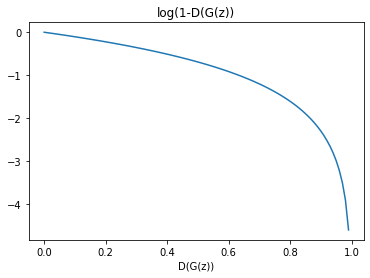

In [14]:
plt.title('log(1-D(G(z))')
x = np.arange(0, 1.0, 0.01)
y = np.log(1-x)
plt.xlabel('D(G(z))')
plt.plot(x,y)

위의 loss plot에서 볼 수 있듯이, Generator는 Discriminator를 속이는 것에 성공할 수록 $D_{\theta}(G_{\phi}(z)) \approx 1$ 낮은 loss를 갖게 됩니다. 

하지만, 이미지 생성의 난이도를 생각하면, 학습 초반에 Discriminator에 비해 Generator가 못하는 일은 자명한 일입니다. 이 때, D(G(z))가 0에 가까운 지점 $D_{\theta}(G_{\phi}(z)) \approx 0$ 에서의 함수의 기울기가 너무 작기 때문에 학습 초반에 Generator가 충분한 양의 학습 시그널을 받지 못하게 되는 문제점이 발생하게 됩니다.

따라서, 위의 식과 직관적으로 유사한 의미를 가지는 다른 loss function을 정의해보도록 하겠습니다.

\begin{equation}
\mathcal{L}_{G_{\phi}} = -E_{z}[\log(D_{\theta}(G_{\phi}(z))]  \tag{2}
\end{equation}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


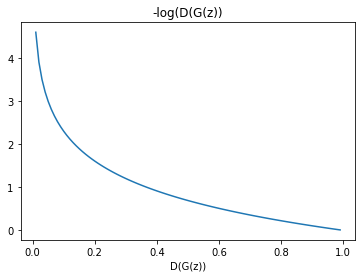

In [15]:
plt.title('-log(D(G(z))')
x = np.arange(0, 1.0, 0.01)
y = -np.log(x)
plt.xlabel('D(G(z))')
plt.plot(x,y)

위의 loss plot에서 볼 수 있듯이, Generator는 여전히 Discriminator를 속이는 것에 성공할 수록 $D_{\theta}(G_{\phi}(z)) \approx 1$ 낮은 loss를 갖게 됩니다. 

하지만, 이전과는 달리 $D_{\theta}(G_{\phi}(z)) \approx 0$에서의 gradient가 크기 때문에 학습 초반에 이미지를 생성하지 못할 때 오히려 충분한 양의 학습 시그널을 받을 수 있게 됩니다.

따라서, 이번 과제에서는 Generator의 Loss로 두번째 식을 사용하도록 하겠습니다.

In [16]:
# Utility Functions
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def save_checkpoint(model, save_path, device):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))
    torch.save(model.cpu().state_dict(), save_path)
    model.to(device)

def load_checkpoint(model, checkpoint_path, device):
    if not os.path.exists(checkpoint_path):
        print("Invalid path!")
        return
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)

class FolderDataset(data.Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.image_list = os.listdir(folder)
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

    def __getitem__(self, index):
        image = Image.open(os.path.join(self.folder, self.image_list[index]))
        return self.transform(image)

    def __len__(self):
        return len(self.image_list)


# Trainer
class Trainer():
    def __init__(self, 
                 trainloader, 
                 testloader, 
                 generator, 
                 discriminator, 
                 criterion,
                 g_optimizer, 
                 d_optimizer, 
                 device):
        """
        trainloader: train data's loader
        testloader: test data's loader
        generator: generator
        discriminator: discriminator
        criterion: loss function to evaluate the model (e.g., BCE Loss)
        g_optimizer: optimizer for generator
        d_optimizer: optimizer for discriminator
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.G = generator
        self.D = discriminator
        self.criterion = criterion
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.device = device

        # Make directory to save the images & models for a specific checkpoint
        os.makedirs(os.path.join('./results/', 'images'), exist_ok=True)
        os.makedirs(os.path.join('./results/', 'checkpoints'), exist_ok=True)
        os.makedirs(os.path.join('./results/', 'evaluation'), exist_ok=True)
        
    def train(self, epochs = 1):
        self.G.to(self.device)
        self.D.to(self.device)

        start_time = time.time()
        for epoch in range(epochs):
            for iter, (real_img, _) in enumerate(self.trainloader):
                self.G.train()
                self.D.train()
                
                batch_size = real_img.size(0)
                real_label = torch.ones(batch_size).to(self.device)
                fake_label = torch.zeros(batch_size).to(self.device)
                # get real CIFAR-10 image
                real_img = real_img.to(self.device)
                # initialize latent_vector to feed into the Generator
                z = torch.randn(real_img.size(0), 256).to(self.device)

                ##########################################################################################
                # Discriminator Loss 구현                                                                #
                # Note : Discriminator Loss는 Generator network의 parameter에 영향을 주지 않아야 합니다. #
                #        detach() function을 참고하세요.                                                 #
                #        https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html              #
                ##########################################################################################
                D_loss: torch.Tensor = None
                ### YOUR CODE HERE (~ 4 lines)
                real_out = self.D(real_img)
                fake_img = self.G(z)
                fake_out = self.D(fake_img.detach())
                D_loss = self.criterion(real_out, real_label) + self.criterion(fake_out, fake_label)
                ### END YOUR CODE

                # TEST CODE
                # (TEST의 통과가 맞는 구현을 보장하지는 못합니다. 일반적으로는 loss가 1.38~1.45 사이의 값이 나와야 합니다.)
                if epoch == 0 and iter == 0:
                    assert D_loss.detach().allclose(torch.tensor(1.4000), atol=2e-1), \
                    f"Discriminator Loss of the model does not match expected result."
                    print("==Discriminator loss function test passed!==")

                self.D.zero_grad()
                D_loss.backward()
                self.d_optimizer.step()

                #######################################################
                # Generator Loss 구현                                 #
                # Note : 위의 정의된 두번 째 식을 사용해서 구현하세요 #
                #######################################################
                G_loss: torch.Tensor = None
                ### YOUR CODE HERE (~ 3 lines)
                fake_img = self.G(z)
                fake_out = self.D(fake_img)
                G_loss = self.criterion(fake_out, real_label)
                ### END YOUR CODE

                # Test code
                # (TEST의 통과가 맞는 구현을 보장하지는 못합니다. 일반적으로는 loss가 1.35~1.52 사이의 값이 나와야 합니다.)
                if epoch == 0 and iter == 0:
                    assert G_loss.detach().allclose(torch.tensor(1.5), atol=2e-1), \
                    f"Generator Loss of the model does not match expected result."
                    print("==Generator loss function test passed!==")

                self.G.zero_grad()
                G_loss.backward()
                self.g_optimizer.step()

            # verbose
            end_time = time.time() - start_time
            end_time = str(datetime.timedelta(seconds=end_time))[:-7]
            print('Time [%s], Epoch [%d/%d], lossD: %.4f, lossG: %.4f'
                  % (end_time, epoch+1, epochs, D_loss.item(), G_loss.item()))

            # Save Images
            fake_img = fake_img.reshape(fake_img.size(0), 3, 32, 32)
            torchvision.utils.save_image(denorm(fake_img), os.path.join('./results/', 'images', 'fake_image-{:03d}.png'.format(epoch+1)))
            if epoch % 10 == 0:
                self.test()

        # Save Checkpoints
        save_checkpoint(self.G, os.path.join('./results', 'checkpoints', 'G_final.pth'), self.device)
        save_checkpoint(self.D, os.path.join('./results', 'checkpoints', 'D_final.pth'), self.device)

    def test(self):
        print('Start computing Inception Score')
        self.G.eval()
        with torch.no_grad():
            for iter in tqdm.tqdm(range(5000)):
                z = torch.randn(1, 256).to(self.device)
                fake_img = self.G(z)
                torchvision.utils.save_image(denorm(fake_img), os.path.join('./results/', 'evaluation', 'fake_image-{:03d}.png'.format(iter)))

        # Compute the Inception score
        dataset = FolderDataset(folder = os.path.join('./results/', 'evaluation'))
        Inception = Inception_Score(dataset)
        score = Inception.compute_score(splits=1)
        print('Inception Score : ', score)

### Train

자, 이제 학습을 진행해 보겠습니다.
학습이 진행됨에 따라 generator가 생성하는 image는 \\
[파일]->[results]->[images]에서 각 epoch별로 확인해보실 수 있습니다.

In [17]:
lr = 2e-4

trainloader, testloader = create_dataloader()
G = Generator()
D = Discriminator()
criterion = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
device = torch.device('cuda')

trainer = Trainer(trainloader=trainloader, 
                  testloader=testloader,
                  generator=G,
                  discriminator=D,
                  criterion=criterion,
                  g_optimizer=g_optimizer,
                  d_optimizer=d_optimizer,
                  device=device)

trainer.train(epochs=50)

Files already downloaded and verified
Files already downloaded and verified
==Discriminator loss function test passed!==
==Generator loss function test passed!==
Time [0:00:47], Epoch [1/50], lossD: 0.2177, lossG: 4.4834
Start computing Inception Score


100%|██████████| 5000/5000 [00:08<00:00, 571.05it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
79it [01:01,  1.28it/s]
100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Inception Score :  2.0722152604102377


Time [0:02:47], Epoch [2/50], lossD: 0.2580, lossG: 2.2199
Time [0:03:35], Epoch [3/50], lossD: 0.4077, lossG: 2.5191
Time [0:04:23], Epoch [4/50], lossD: 0.4489, lossG: 2.7645
Time [0:05:11], Epoch [5/50], lossD: 0.5359, lossG: 5.5390
Time [0:06:00], Epoch [6/50], lossD: 0.4076, lossG: 3.6671
Time [0:06:48], Epoch [7/50], lossD: 0.2684, lossG: 4.1791
Time [0:07:36], Epoch [8/50], lossD: 0.1034, lossG: 4.0335
Time [0:08:24], Epoch [9/50], lossD: 0.0918, lossG: 3.4361
Time [0:09:12], Epoch [10/50], lossD: 0.2844, lossG: 4.5256
Time [0:09:59], Epoch [11/50], lossD: 0.3611, lossG: 4.4674
Start computing Inception Score


100%|██████████| 5000/5000 [00:09<00:00, 550.04it/s]
79it [01:00,  1.30it/s]
100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

Inception Score :  3.7484425122708998


Time [0:11:58], Epoch [12/50], lossD: 0.0975, lossG: 4.1358
Time [0:12:45], Epoch [13/50], lossD: 0.5864, lossG: 1.1035
Time [0:13:32], Epoch [14/50], lossD: 0.8942, lossG: 2.6309
Time [0:14:20], Epoch [15/50], lossD: 0.0431, lossG: 4.4464
Time [0:15:07], Epoch [16/50], lossD: 0.1853, lossG: 4.6425
Time [0:15:54], Epoch [17/50], lossD: 0.0772, lossG: 4.7077
Time [0:16:41], Epoch [18/50], lossD: 0.1442, lossG: 3.6719
Time [0:17:29], Epoch [19/50], lossD: 0.1623, lossG: 4.0677
Time [0:18:16], Epoch [20/50], lossD: 0.1256, lossG: 5.1543
Time [0:19:03], Epoch [21/50], lossD: 0.1338, lossG: 4.3656
Start computing Inception Score


100%|██████████| 5000/5000 [00:08<00:00, 564.61it/s]
79it [01:00,  1.30it/s]
100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

Inception Score :  3.950156360103655


Time [0:21:01], Epoch [22/50], lossD: 0.2091, lossG: 3.8985
Time [0:21:48], Epoch [23/50], lossD: 0.0860, lossG: 5.2119
Time [0:22:35], Epoch [24/50], lossD: 0.2178, lossG: 4.0088
Time [0:23:22], Epoch [25/50], lossD: 0.0957, lossG: 4.8595
Time [0:24:10], Epoch [26/50], lossD: 0.1863, lossG: 3.6236
Time [0:24:57], Epoch [27/50], lossD: 0.0279, lossG: 4.5394
Time [0:25:45], Epoch [28/50], lossD: 0.1260, lossG: 4.4608
Time [0:26:32], Epoch [29/50], lossD: 0.0249, lossG: 5.4409
Time [0:27:19], Epoch [30/50], lossD: 0.1852, lossG: 3.5242
Time [0:28:06], Epoch [31/50], lossD: 0.1917, lossG: 2.5745
Start computing Inception Score


100%|██████████| 5000/5000 [00:08<00:00, 564.74it/s]
79it [01:00,  1.30it/s]
100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

Inception Score :  4.212877004134691


Time [0:30:04], Epoch [32/50], lossD: 0.0743, lossG: 5.2845
Time [0:30:51], Epoch [33/50], lossD: 0.1738, lossG: 4.6336
Time [0:31:38], Epoch [34/50], lossD: 0.6574, lossG: 2.5570
Time [0:32:25], Epoch [35/50], lossD: 0.0857, lossG: 3.9621
Time [0:33:13], Epoch [36/50], lossD: 0.0477, lossG: 4.4689
Time [0:34:00], Epoch [37/50], lossD: 0.2681, lossG: 6.3673
Time [0:34:47], Epoch [38/50], lossD: 0.0640, lossG: 5.4857
Time [0:35:34], Epoch [39/50], lossD: 0.3815, lossG: 2.1046
Time [0:36:21], Epoch [40/50], lossD: 0.1141, lossG: 3.5499
Time [0:37:08], Epoch [41/50], lossD: 0.0660, lossG: 6.5942
Start computing Inception Score


100%|██████████| 5000/5000 [00:09<00:00, 542.02it/s]
79it [01:00,  1.30it/s]
100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Inception Score :  3.9950488695627064


Time [0:39:06], Epoch [42/50], lossD: 0.0250, lossG: 6.8565
Time [0:39:54], Epoch [43/50], lossD: 0.1399, lossG: 5.1342
Time [0:40:41], Epoch [44/50], lossD: 0.3743, lossG: 2.3584
Time [0:41:28], Epoch [45/50], lossD: 0.1101, lossG: 6.0654
Time [0:42:15], Epoch [46/50], lossD: 0.0939, lossG: 5.3856
Time [0:43:03], Epoch [47/50], lossD: 0.0796, lossG: 4.6636
Time [0:43:50], Epoch [48/50], lossD: 0.0948, lossG: 5.2483
Time [0:44:37], Epoch [49/50], lossD: 0.0683, lossG: 5.4519
Time [0:45:24], Epoch [50/50], lossD: 0.0130, lossG: 6.7613
